In [1]:
import tensorflow as tf
print(tf.__version__)

#data visulalization
import matplotlib.pyplot as plt

#data preprocessing
import pandas as pd
from keras import regularizers

#math operations
import numpy as np

#data scaling
from sklearn.preprocessing import StandardScaler

#hyperparameter optimization
from sklearn.model_selection import GridSearchCV

#kernel ridge model
from sklearn.kernel_ridge import KernelRidge

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2.1.0


Using TensorFlow backend.


/kaggle/input/LANL-Earthquake-Prediction/train.csv
/kaggle/input/LANL-Earthquake-Prediction/sample_submission.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_4b0839.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_703cea.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_d19980.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_84c7fb.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_6968c8.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_3d6e79.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_b9ad7f.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_78d817.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_aa78e0.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_1b78af.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_4ae37c.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_f01368.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_caa919.csv
/kaggle/input/LANL-Earthquake-Prediction/test/seg_2883ec.csv
/kaggle/input/LANL-Earthquake-Pr

In [2]:
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
print(train.shape)
train.head(10)

(629145480, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


(6291455,)


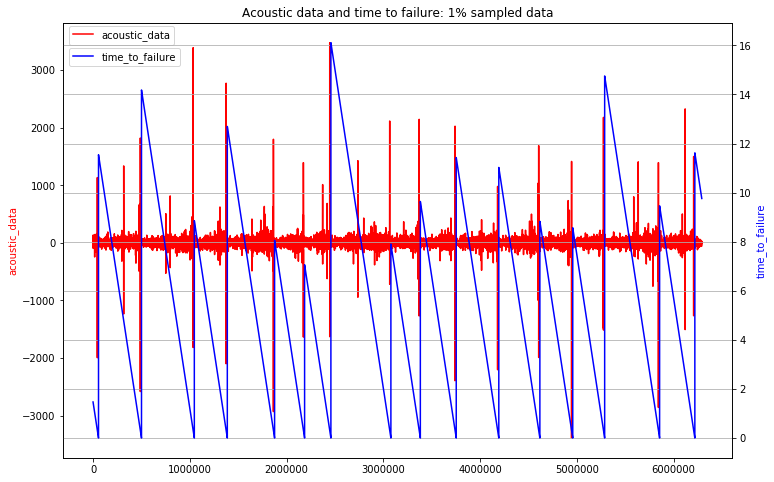

In [3]:
#visualise 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]
print(train_ad_sample_df.shape)
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic_data', color = 'r')
    plt.legend(['acoustic_data'], loc=(0.01,0.95))
    ax2=ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time_to_failure', color = 'b')
    plt.legend(['time_to_failure'], loc = (0.01,0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [4]:
# plot 150k sample slices of the training data, matches size of test data (~0.375 seconds long)
# plots signal and decreasing time to the next quake
# np.random.seed(2018)
rand_idxs = np.random.randint(150000, 629145480*3/4-150000, size=1000, dtype=np.int32)
rand_idxs_valid = np.random.randint(low = 629145480*3/4, high = 629145480-150000, size = 1000, dtype=np.int32)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, input_shape=(150000,), activation="relu", kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.02)),
    tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.02)),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.02)),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(-epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
model.summary()
print(rand_idxs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               76800512  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 76,940,097
Trainable params: 76,940,097
Non-trainable params: 0
_________________________________________________________________
[128096838 376414002 300568525  68723328 407494877 453928942 431782614
 336649399 354388097 110622849 396456819   9245609 400521789  49629519
 438283567 422682661 124444654 212561883 397867096 395449979 140373286
 342039893 126324913 13286568

In [5]:
ad = pd.DataFrame(train['acoustic_data'].values[0: 150000].reshape((1, 150000)))
ttf = pd.Series(train['time_to_failure'].values[0: 150000][-1])
print(ad.shape,ttf.shape,type(ad))
history = model.fit(x=ad, y=ttf,  epochs=100, verbose=1, batch_size= 512, callbacks=[lr_schedule])
del ad, ttf

(1, 150000) (1,) <class 'pandas.core.frame.DataFrame'>
Train on 1 samples
Epoch 1/100
1/1 [==============================] - 2s 2s/sample - loss: 70.3768 - mae: 0.4308
Epoch 2/100
1/1 [==============================] - 0s 21ms/sample - loss: 69.8074 - mae: 0.4308
Epoch 3/100
1/1 [==============================] - 0s 21ms/sample - loss: 69.3027 - mae: 0.4308
Epoch 4/100
1/1 [==============================] - 0s 20ms/sample - loss: 68.8526 - mae: 0.4308
Epoch 5/100
1/1 [==============================] - 0s 22ms/sample - loss: 68.4560 - mae: 0.4308
Epoch 6/100
1/1 [==============================] - 0s 19ms/sample - loss: 68.1035 - mae: 0.4308
Epoch 7/100
1/1 [==============================] - 0s 18ms/sample - loss: 67.7904 - mae: 0.4308
Epoch 8/100
1/1 [==============================] - 0s 19ms/sample - loss: 67.5127 - mae: 0.4308
Epoch 9/100
1/1 [==============================] - 0s 18ms/sample - loss: 67.2658 - mae: 0.4308
Epoch 10/100
1/1 [==============================] - 0s 18ms/samp

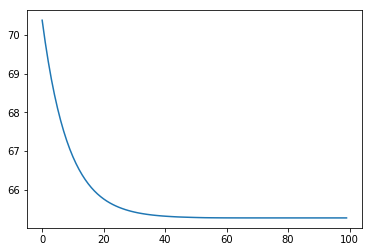

In [6]:
# history.history
plt.plot(history.history["loss"])
# plt.axis([5e-10, 5e-8, 0.095, 0.1])

In [7]:
error_train=[]
error_valid=[]
coun = 0
for st_idx, st_idx_valid in zip(rand_idxs, rand_idxs_valid):
    ad = pd.DataFrame(train['acoustic_data'].values[st_idx: st_idx + 150000].reshape((1, 150000))).to_numpy()
    ttf = pd.Series(train['time_to_failure'].values[st_idx: st_idx + 150000][-1]).to_numpy()
    ad_valid = pd.DataFrame(train['acoustic_data'].values[st_idx_valid: st_idx_valid + 150000].reshape((1, 150000))).to_numpy()
    ttf_valid = pd.Series(train['time_to_failure'].values[st_idx_valid: st_idx_valid + 150000][-1]).to_numpy()
    coun = coun+1
    print(ad.shape,ttf.shape,type(ad))
    print(coun)
    history=model.fit(x=ad, y=ttf,  epochs=50, verbose=1, callbacks=[lr_schedule], validation_data=(ad_valid, ttf_valid))
    error_train.append(history.history['mae'])
    error_valid.append(history.history['val_mae'])
del ad, ttf, ad_valid, ttf_valid

(1, 150000) (1,) <class 'numpy.ndarray'>
1
Train on 1 samples, validate on 1 samples
Epoch 1/50
1/1 [==============================] - 0s 187ms/sample - loss: 90.5652 - mae: 1.7345 - val_loss: 62.3412 - val_mae: 6.2581
Epoch 2/50
1/1 [==============================] - 0s 28ms/sample - loss: 90.0439 - mae: 1.7345 - val_loss: 62.1243 - val_mae: 6.2581
Epoch 3/50
1/1 [==============================] - 0s 29ms/sample - loss: 89.4569 - mae: 1.7345 - val_loss: 61.9273 - val_mae: 6.2581
Epoch 4/50
1/1 [==============================] - 0s 28ms/sample - loss: 88.8585 - mae: 1.7345 - val_loss: 61.7497 - val_mae: 6.2581
Epoch 5/50
1/1 [==============================] - 0s 27ms/sample - loss: 88.2779 - mae: 1.7345 - val_loss: 61.5918 - val_mae: 6.2581
Epoch 6/50
1/1 [==============================] - 0s 27ms/sample - loss: 87.7343 - mae: 1.7345 - val_loss: 61.4525 - val_mae: 6.2581
Epoch 7/50
1/1 [==============================] - 0s 27ms/sample - loss: 87.2300 - mae: 1.7345 - val_loss: 61.3297 -

In [8]:
print(np.mean(error_train))
print(np.mean(error_valid))

5.3889074
5.0382094


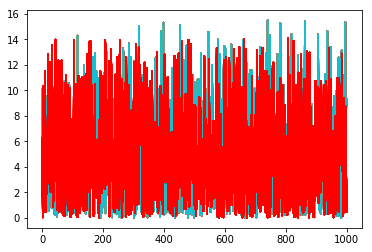

In [9]:
plt.plot(error_train)
plt.plot(error_valid, 'r')

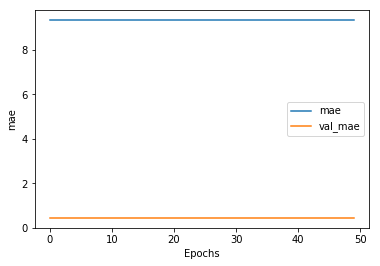

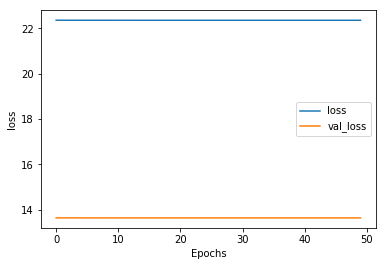

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "mae")
plot_graphs(history, "loss")

In [11]:
import statistics
import scipy.stats as stats
rand_idxs = np.random.randint(0, 629145480*3/4-150000, size=1000, dtype=np.int32)
rand_idxs_valid = np.random.randint(low = 629145480*3/4, high = 629145480-150000, size = 1000, dtype=np.int32)
def sample_statistics(X_EQ):
    X_statistics=[]
    X_statistics.append(X_EQ.mean())
    X_statistics.append(X_EQ.std())
    X_statistics.append(X_EQ.min())
    X_statistics.append(stats.kurtosis(X_EQ))
    X_statistics.append(stats.skew(X_EQ))

    return X_statistics


In [12]:
X_train = []
y_train = []
X_test = []
y_test = []
for st_idx, st_idx_valid in zip(rand_idxs, rand_idxs_valid):
    X_train.append(sample_statistics(train['acoustic_data'].values[st_idx: st_idx + 150000]))
    y_train.append(pd.Series(train['time_to_failure'].values[st_idx: st_idx + 150000][-1]).to_numpy())
    X_test.append(sample_statistics(train['acoustic_data'].values[st_idx_valid: st_idx_valid + 150000]))
    y_test.append(pd.Series(train['time_to_failure'].values[st_idx_valid: st_idx_valid + 150000][-1]).to_numpy())
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_train.reshape(len(y_train),)
y_test.reshape(len(y_test),)

array([10.26309775,  4.9555992 ,  6.74949909,  6.25079747, 11.2982971 ,
       10.61519757,  8.63279702,  2.63829803,  0.59219887, 11.36299974,
        8.15509684, 10.90889625,  0.89999788,  8.01989564,  8.62639646,
        9.58189974,  4.7747976 ,  4.24699956,  2.49039613,  1.46679908,
        6.92189805,  5.97339759,  6.60509775,  4.71889753,  1.00639811,
        7.31259555, 10.23009736,  2.4020983 ,  3.3260964 ,  2.2578972 ,
        2.54489898,  6.07019709,  7.13469792,  3.04039691, 12.60149688,
        8.03699696,  3.46179576,  5.68239927,  8.21809959,  1.6551992 ,
        8.15079819,  7.75609604,  7.91569778,  0.26979832, 11.18549808,
        3.50219697,  4.397097  ,  9.79679773,  5.23889918, 12.41419815,
        5.30599888,  0.86269968,  5.71109889,  2.90429886, 11.02909671,
        0.40179985,  0.04849593,  4.5536966 ,  3.23409767,  1.46359977,
        7.69889926,  9.88209962,  2.843898  ,  0.99009621, 10.86419668,
        7.4495994 ,  1.34979815,  3.10219693,  5.93479744,  1.57

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)})
svr.fit(X_train, y_train)
y_svr = svr.predict(X_test)
print(svr.best_score_, svr.best_params_)


kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)})
kr.fit(X_train, y_train)
y_kr = kr.predict(X_test)
print(kr.best_score_, kr.best_params_)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

0.22993954008913836 {'C': 1.0, 'gamma': 0.01}


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.011231940312944812 {'alpha': 0.1, 'gamma': 0.01}


In [14]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, y_svr))
print(mean_absolute_error(y_test, y_kr))

2.61049250203453
2.8034978751330035


In [15]:
print(os.listdir("../input/LANL-Earthquake-Prediction/test"))

['seg_4b0839.csv', 'seg_703cea.csv', 'seg_d19980.csv', 'seg_84c7fb.csv', 'seg_6968c8.csv', 'seg_3d6e79.csv', 'seg_b9ad7f.csv', 'seg_78d817.csv', 'seg_aa78e0.csv', 'seg_1b78af.csv', 'seg_4ae37c.csv', 'seg_f01368.csv', 'seg_caa919.csv', 'seg_2883ec.csv', 'seg_0fca83.csv', 'seg_a6c5cc.csv', 'seg_0df75c.csv', 'seg_e051bc.csv', 'seg_c3836b.csv', 'seg_6e7f73.csv', 'seg_7df3dd.csv', 'seg_a0a423.csv', 'seg_421da1.csv', 'seg_7fa6ec.csv', 'seg_e71dda.csv', 'seg_81a8ea.csv', 'seg_397dc9.csv', 'seg_f19f8e.csv', 'seg_7a521c.csv', 'seg_eccb17.csv', 'seg_27de37.csv', 'seg_7ce9cb.csv', 'seg_72859b.csv', 'seg_03f380.csv', 'seg_f6cfd4.csv', 'seg_075340.csv', 'seg_34a8f7.csv', 'seg_aeeb31.csv', 'seg_d1a8b3.csv', 'seg_b87cf5.csv', 'seg_6fd5bb.csv', 'seg_7f5b6f.csv', 'seg_b9de03.csv', 'seg_7cd6b1.csv', 'seg_35ba8f.csv', 'seg_23bdf9.csv', 'seg_3f3689.csv', 'seg_563059.csv', 'seg_eb47a9.csv', 'seg_eefd4a.csv', 'seg_29a073.csv', 'seg_d2551a.csv', 'seg_fe73b1.csv', 'seg_c7b424.csv', 'seg_ddd206.csv', 'seg_2ba7

In [16]:
ld = os.listdir("../input/LANL-Earthquake-Prediction/test")
type(ld)
test_list=[]
for strin in ld:
    if 'seg' in strin:
        test_list.append(strin)


In [17]:
X_test_1 = []
for test_ex1 in test_list:
    test_data1=sample_statistics(pd.read_csv("../input/LANL-Earthquake-Prediction/test/"+test_ex1, dtype={'acoustic_data': np.int16}).values)
    X_test_1.append(test_data1)

In [18]:
prediction = svr.predict(X_test_1)
test_list=np.char.replace(np.asarray(test_list), ".csv", "")
forecast = pd.DataFrame(columns=['seg_id', 'time_to_failure'])
forecast['seg_id'] = test_list
forecast['time_to_failure'] = prediction
print(forecast)
forecast.to_csv("submission.csv", index = False, sep=',', encoding='utf-8')

          seg_id  time_to_failure
0     seg_4b0839         3.419416
1     seg_703cea         5.101566
2     seg_d19980         5.656595
3     seg_84c7fb         3.835297
4     seg_6968c8         3.899874
...          ...              ...
2619  seg_d59e4e         5.399272
2620  seg_16a270         7.072911
2621  seg_12b9ba         5.722886
2622  seg_03d386         5.045076
2623  seg_010eab         6.898428

[2624 rows x 2 columns]


In [19]:
pd.read_csv('submission.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

,seg_id,time_to_failure
0,seg_4b0839,3.419416
1,seg_703cea,5.101566
2,seg_d19980,5.656595
3,seg_84c7fb,3.835297
4,seg_6968c8,3.899874
...,...,...
2619,seg_d59e4e,5.399272
2620,seg_16a270,7.072911
2621,seg_12b9ba,5.722886
2622,seg_03d386,5.045076
